In [46]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import silhouette_score
from textblob import TextBlob
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import entropy
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import logging

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aravi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aravi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\aravi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aravi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [47]:
# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class SentimentAnalysis:
    def __init__(self, data):
        if not {'timestamp', 'sender', 'message'}.issubset(data.columns):
            raise ValueError("Input data must contain 'timestamp', 'sender', and 'message' columns.")
        self.data = data.dropna(subset=['message']).reset_index(drop=True)
        self.documents = None
        self.lemmatizer = WordNetLemmatizer() # Initialize lemmatizer
    
    def preprocess_messages(self):
        '''Preprocess messages: tokenize, remove stopwords, and punctuation.'''
        try:
            stop_words = set(stopwords.words('english'))
            documents = []
            for message in self.data['message']:
                # Tokenize, convert to lowercase, remove stop words and punctuation
                tokens = word_tokenize(message.lower())
                tokens = [self.lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and word not in string.punctuation]
                documents.append(tokens)
                
            self.documents = documents
            return documents
        except Exception as e:
            logging.error(f'Error during message preprocessing: {e}')

    def topic_modeling_coherence(self, n_topics=5, max_df=0.95, min_df=2, stop_words='english', learning_method='online', max_iter=100, num_topics_range=range(2, 11), coherence_metric='c_v'):
        '''Perform Topic Modeling using Latent Dirichlet Allocation (LDA) and calculate coherence scores.'''
        try:
            # Use TF-IDF Vectorizer
            vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words=stop_words)
            doc_term_matrix = vectorizer.fit_transform(self.data['message'])

            # Create the LDA model
            lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method=learning_method, max_iter=max_iter, random_state=42)
            lda_output = lda_model.fit_transform(doc_term_matrix)

            # Print top words for each topic
            feature_names = vectorizer.get_feature_names_out()
            for topic_idx, topic in enumerate(lda_model.components_):
                top_words = [feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
                logging.info(f"Topic {topic_idx + 1}: {', '.join(top_words)}")
            
            # Calculate silhouette score for topic modeling
            if n_topics > 1:
                silhouette_avg = silhouette_score(doc_term_matrix.toarray(), lda_output.argmax(axis=1))
                logging.info(f'Silhouette Score for {n_topics} topics: {silhouette_avg:.4f}')
            
            # Calculate coherence scores for varying number of topics
            if not self.documents:
                logging.error('Documents are not preprocessed. Run preprocess_messages() first.')
                return
            
            # Create dictionary and corpus for coherence calculation
            dictionary = corpora.Dictionary(self.documents)
            corpus = [dictionary.doc2bow(doc) for doc in self.documents]

            # Coherence scores
            coherence_scores = {}
            for num_topics in num_topics_range:
                try:
                    # Train LDA model
                    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42)

                    # Calculate coherence score
                    coherence_model = CoherenceModel(model=lda_model, texts=self.documents, dictionary=dictionary, coherence=coherence_metric)
                    coherence_scores[num_topics] = coherence_model.get_coherence()
                except Exception as e:
                    logging.error(f'Error calculating coherence for {num_topics} topics: {e}')

            # Visualization
            plt.style.use('dark_background')
            plt.Figure(figsize=(10, 6))
            plt.plot(list(coherence_scores.keys()), list(coherence_scores.values()), marker='o', color='#128C7E')
            plt.title('Topic Coherence Scores', fontsize=16, color='#25D366')
            plt.xlabel('Number of Topics')
            plt.ylabel('Coherence Score')
            plt.grid(False)
            plt.tight_layout()
            plt.show()
            
            return lda_model, lda_output, coherence_scores
        except Exception as e:
            logging.error(f'Error during topic modeling and coherence calculation: {e}')
    
    def sentiment_analysis(self):
        '''Perform Sentiment Analysis on messages'''
        try:
            self.data['sentiment_polarity'] = self.data['message'].apply(lambda x: TextBlob(x).sentiment.polarity)
            self.data['sentiment_category'] = self.data['sentiment_polarity'].apply(
                lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral')
            )

            # Sentiment distribution
            sentiment_dist = self.data['sentiment_category'].value_counts()

            # Visualization
            plt.style.use('dark_background')
            plt.figure(figsize=(10, 6))
            wedges, texts, autotexts = plt.pie(sentiment_dist, labels=sentiment_dist.index, autopct='%1.1f%%', colors=['#ECE5DD', '#509E2F', '#971B2F'])
            plt.title('Sentiment Distribution', fontsize=16, color='#25D366')

            # Change pct color 
            for autotext in autotexts:
                autotext.set_color('black')

            plt.tight_layout()
            plt.show()

            # Calculate sentiment metrics
            positive_count = sentiment_dist.get('positive', 0)
            negative_count = sentiment_dist.get('negative', 0)
            neutral_count = sentiment_dist.get('neutral', 0)
            total_count = len(self.data)

            logging.info(f'\n Sentiment Analysis Metrics: \n Positive: {positive_count / total_count:.2%} \n Negative: {negative_count / total_count:.2%} \n Neutral: {neutral_count / total_count:.2%}')

            return self.data[['message', 'sentiment_polarity', 'sentiment_category']]
        except Exception as e:
            logging.error(f'Error during sentiment analysis: {e}')
    
    def analyze_response_time(self):
        '''Analyze response times between messages from different senders.'''
        try:
            self.data['timestamp'] = pd.to_datetime(self.data['timestamp'], errors='coerce')
            self.data = self.data.dropna(subset=['timestamp']).sort_values('timestamp')
            self.data['prev_sender'] = self.data['sender'].shift()
            self.data['response_time'] = (self.data['timestamp'] - self.data['timestamp'].shift()).dt.total_seconds() / 60

            response_times = self.data[self.data['sender'] != self.data['prev_sender']]['response_time'].dropna()

            logging.info(
                f'\n Response Time Statistics: \n Mean: {response_times.mean():.2f} min \n Median: {response_times.median():.2f} min \n Max: {response_times.max():.2f} min'
            )

            return response_times.describe()
        except Exception as e:
            logging.error(f'Error during response time analysis: {e}')
    
    def calculate_linguistic_complexity(self):
        '''Calculate linguistic complexity metrics for messages.'''
        try:
            words = ' '.join(self.data['message']).lower().split()
            unique_words = set(words)
            type_token_ratio = len(unique_words) / len(words) if words else 0 # Calculates the diversity of vocabulary in a text

            # Word entropy
            word_freq = Counter(words)
            word_entropy = entropy(list(word_freq.values())) if words else 0 # Measures the linguistic complexity that quantifies unpredictability or randomness of words

            # Average sentence length
            avg_sentence_length = np.mean([len(sentence.split()) for sentence in self.data['message']]) if words else 0

            logging.info(
                f'\n Linguistic Complexity Metrics: \n Type-Token Ratio (TTR): {type_token_ratio:.2f} \n Word Entropy: {word_entropy:.2f} \n Average Sentence Length: {avg_sentence_length:.2f}'
            )
            
            return {
                'Type-Token Ratio (TTR)': type_token_ratio,
                'Word Entropy': word_entropy,
                'Average Sentence Length': avg_sentence_length
            }
        except Exception as e:
            logging.error(f'Error during linguistic complexity calculation: {e}')
    
    def export_to_csv(self, output_path):
        '''
        Export the updated data to a CSV file.
        output_path: Path to save the CSV file.
        '''
        self.data.to_csv(output_path, index=False)
        print(f'Updated data exported successfully to {output_path}')

2025-01-28 13:52:05,112 - INFO - Topic 1: dhan, nu, la, ah, https
2025-01-28 13:52:05,113 - INFO - Topic 2: la, https, ah, dhan, nu
2025-01-28 13:52:06,582 - INFO - Silhouette Score for 2 topics: 0.7983
2025-01-28 13:52:06,583 - INFO - adding document #0 to Dictionary<0 unique tokens: []>
2025-01-28 13:52:06,626 - INFO - adding document #10000 to Dictionary<11975 unique tokens: ['..', '...', 'age', 'csk', 'dheiva']...>
2025-01-28 13:52:06,635 - INFO - built Dictionary<13776 unique tokens: ['..', '...', 'age', 'csk', 'dheiva']...> from 11860 documents (total 52286 corpus positions)
2025-01-28 13:52:06,635 - INFO - Dictionary lifecycle event {'msg': "built Dictionary<13776 unique tokens: ['..', '...', 'age', 'csk', 'dheiva']...> from 11860 documents (total 52286 corpus positions)", 'datetime': '2025-01-28T13:52:06.635777', 'gensim': '4.3.3', 'python': '3.12.8 (tags/v3.12.8:2dc476b, Dec  3 2024, 19:30:04) [MSC v.1942 64 bit (AMD64)]', 'platform': 'Windows-11-10.0.26100-SP0', 'event': 'cre

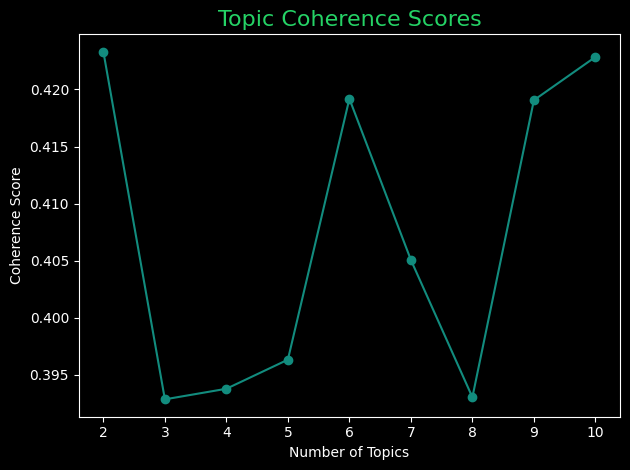

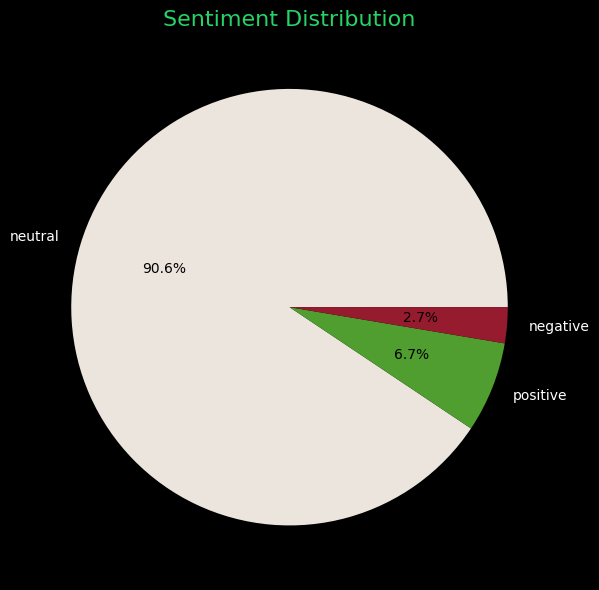

2025-01-28 13:54:03,749 - INFO - 
 Sentiment Analysis Metrics: 
 Positive: 6.72% 
 Negative: 2.66% 
 Neutral: 90.62%
2025-01-28 13:54:03,766 - INFO - 
 Response Time Statistics: 
 Mean: 199.30 min 
 Median: 7.00 min 
 Max: 8578.00 min
2025-01-28 13:54:03,791 - INFO - 
 Linguistic Complexity Metrics: 
 Type-Token Ratio (TTR): 0.34 
 Word Entropy: 8.48 
 Average Sentence Length: 4.20


Updated data exported successfully to Whatsapp_Chat.csv


In [48]:
# Load the data
data = pd.read_csv('Whatsapp_Chat.csv')

# Intialize the class with the data
sentiment = SentimentAnalysis(data)

# Preprocess messages
preprocessed_docs = sentiment.preprocess_messages()

# Topic modeling and coherence scores
lda_model, lda_output, coherence_scores = sentiment.topic_modeling_coherence(n_topics=2, max_df=1.0, min_df=350)

# Sentiment Analysis
sentiment_results = sentiment.sentiment_analysis()

# Response time analysis
response_stats = sentiment.analyze_response_time()

# Linguistic complexity metrics
complexity_metrics = sentiment.calculate_linguistic_complexity()

# Export updated data to CSV
sentiment.export_to_csv('Whatsapp_Chat.csv')